<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


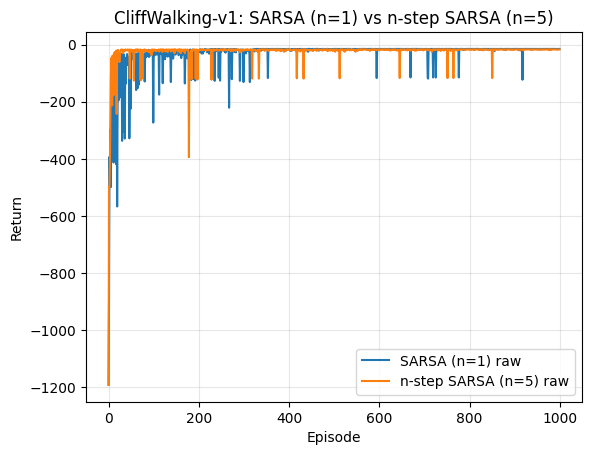

In [55]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# ---------- Shared hyperparameters ----------
ALPHA = 0.1
GAMMA = 0.99
EPS_START, EPS_END = 0.10, 0.01
N_EPISODES = 1000
MAX_STEPS_PER_EP = 300
SEED = 0
ENV_ID = "CliffWalking-v1"

def eps_decay(ep, n_episodes=N_EPISODES, eps_start=EPS_START, eps_end=EPS_END):
    frac = ep / max(1, n_episodes - 1)
    return eps_start + (eps_end - eps_start) * frac

def train_nstep_sarsa(
    env_id=ENV_ID,
    n_step=1,
    alpha=ALPHA,
    gamma=GAMMA,
    n_episodes=N_EPISODES,
    max_steps_per_ep=MAX_STEPS_PER_EP,
    seed=SEED,
):
    """Returns episode_returns (len=n_episodes) and learned Q-table."""
    env = gym.make(env_id)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    rng = np.random.default_rng(seed)
    buf_len = n_step + 1
    gamma_pows = gamma ** np.arange(n_step, dtype=np.float32)  # [γ^0..γ^{n-1}]

    def eps_greedy(s, eps):
        if rng.random() < eps:
            return int(rng.integers(nA))
        row = Q[s]
        best = np.flatnonzero(row == row.max())
        return int(rng.choice(best))

    episode_returns = []

    for ep in range(n_episodes):
        eps = eps_decay(ep, n_episodes)
        s, _ = env.reset(seed=seed + ep)  # deterministic per run, varied per-ep
        G_ep = 0.0

        # ring buffers
        S = np.empty(buf_len, dtype=np.int32)
        A = np.empty(buf_len, dtype=np.int32)
        R = np.zeros(buf_len, dtype=np.float32)

        S[0] = s
        A[0] = eps_greedy(s, eps)

        T = np.inf
        t = 0
        steps = 0

        while True:
            if t < T:
                idx_t = t % buf_len
                s_next, r, term, trunc, _ = env.step(A[idx_t])
                done = term or trunc or (steps >= max_steps_per_ep)
                steps += 1

                R[(t + 1) % buf_len] = r
                S[(t + 1) % buf_len] = s_next
                G_ep += r

                if done:
                    T = t + 1
                else:
                    A[(t + 1) % buf_len] = eps_greedy(s_next, eps)

            tau = t - n_step + 1
            if tau >= 0:
                # n-step target
                L = int(min(n_step, T - tau - 1)) if np.isfinite(T) else n_step
                G = 0.0
                for i in range(L):
                    G += gamma_pows[i] * R[(tau + i + 1) % buf_len]
                if tau + n_step < T:  # bootstrap if within episode
                    s_tau_n = S[(tau + n_step) % buf_len]
                    a_tau_n = A[(tau + n_step) % buf_len]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

                s_tau = S[tau % buf_len]
                a_tau = A[tau % buf_len]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break
            t += 1

        episode_returns.append(G_ep)

    env.close()
    return np.array(episode_returns, dtype=np.float32), Q

# ---------- Run both: standard SARSA (n=1) vs n-step (n=5) ----------
rets_sarsa1, Q1 = train_nstep_sarsa(n_step=1)
rets_sarsa5, Q5 = train_nstep_sarsa(n_step=5)

k = 1  # change to 1 to disable smoothing
plt.plot(rets_sarsa1, label="SARSA (n=1) raw")
plt.plot(rets_sarsa5, label="n-step SARSA (n=5) raw")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("CliffWalking-v1: SARSA (n=1) vs n-step SARSA (n=5)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Discussion 

When comparing standard SARSA (n=1) with n-step SARSA (n=5), the n=5 method learns faster at the beginning because it spreads the rewards back more quickly. However, it also shows more ups and downs in the returns. The 1-step SARSA is slower but more stable. In the end, both methods learn to avoid the cliff, but n-step SARSA usually finds the safer path earlier.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




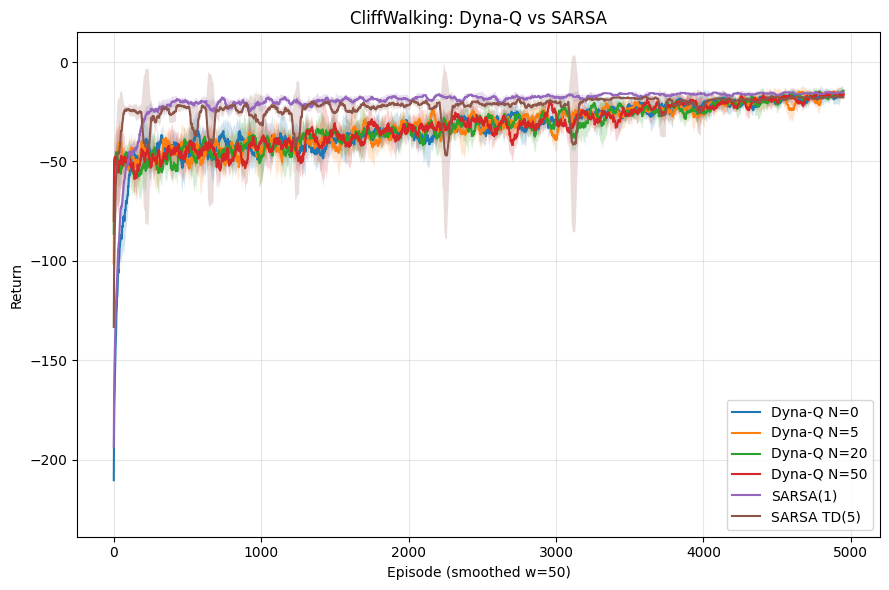

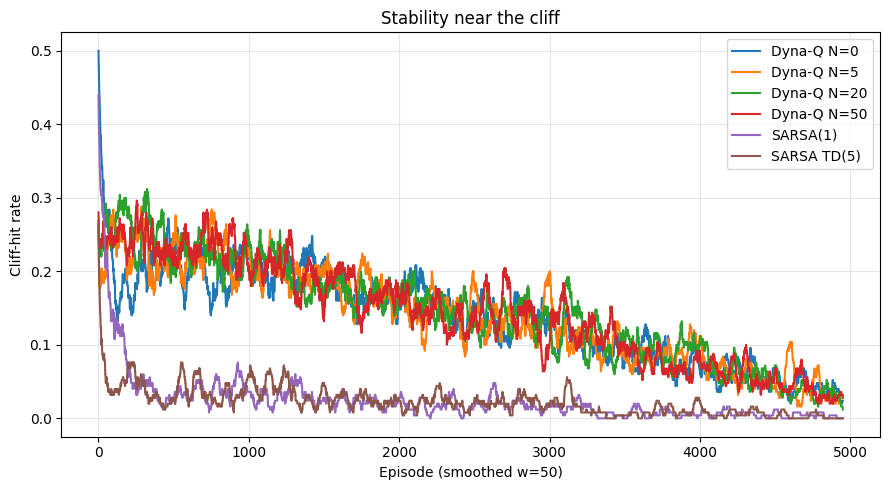

In [35]:
# Ultra-fast Dyna-Q vs SARSA(1) vs SARSA TD(5) on CliffWalking-v1
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# -------------------- knobs --------------------
QUICK = False  # set False to run the full (slow) experiment

if QUICK:
    N_EPISODES   = 400
    SEEDS        = [0, 1]
    DYNA_CONFIGS = [0, 10, 30]   # planning steps
    MAX_STEPS    = 150
else:
    N_EPISODES   = 5000
    SEEDS        = [0, 1, 2, 3, 4]
    DYNA_CONFIGS = [0, 5, 20, 50]
    MAX_STEPS    = 200

ALPHA = 0.1
GAMMA = 0.99
EPS_START, EPS_END = 0.10, 0.01
NS = None  # filled after env make

# -------------------- common utils --------------------
def make_env():
    return gym.make("CliffWalking-v1")

def eps_schedule(ep, total, start=EPS_START, end=EPS_END):
    f = ep / max(1, total - 1)
    return start + (end - start) * f

def greedy_rand_row(row, rng):
    # random tie-break among argmax
    m = row.max()
    mask = (row == m)
    idxs = np.flatnonzero(mask)
    return int(rng.choice(idxs))

def eps_greedy(Q, s, eps, rng):
    if rng.random() < eps:
        return int(rng.integers(Q.shape[1]))
    return greedy_rand_row(Q[s], rng)

def moving_average(x, w=50):
    if len(x) < w:
        return np.array([])
    filt = np.ones(w, dtype=np.float32) / w
    return np.convolve(x, filt, mode="valid")

# -------------------- SARSA(1) --------------------
def sarsa_one_step(n_episodes=N_EPISODES, alpha=ALPHA, gamma=GAMMA, seed=0,
                   max_steps=MAX_STEPS):
    env = make_env()
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    rets, cliffs = np.empty(n_episodes, np.float32), np.empty(n_episodes, np.int8)

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)
        s, _ = env.reset(seed=seed + ep)
        a = eps_greedy(Q, s, eps, rng)
        G = 0.0; fell = 0; steps = 0
        while True:
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc or (steps >= max_steps)
            if r <= -100: fell = 1
            G += r
            if not done:
                a2 = eps_greedy(Q, s2, eps, rng)
                target = r + gamma * Q[s2, a2]
            else:
                a2 = 0
                target = r
            Q[s, a] += alpha * (target - Q[s, a])
            if done: break
            s, a = s2, a2
            steps += 1
        rets[ep] = G; cliffs[ep] = fell
    env.close()
    return Q, rets, cliffs

# -------------------- SARSA n-step (ring buffer) --------------------
def sarsa_n_step(n_step=5, n_episodes=N_EPISODES, alpha=ALPHA, gamma=GAMMA,
                 seed=0, max_steps=MAX_STEPS):
    env = make_env()
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    buf = n_step + 1
    gamma_pows = gamma ** np.arange(n_step, dtype=np.float32)
    rets, cliffs = np.empty(n_episodes, np.float32), np.empty(n_episodes, np.int8)

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)
        S = np.empty(buf, np.int32); A = np.empty(buf, np.int32); R = np.zeros(buf, np.float32)
        s0, _ = env.reset(seed=seed + ep)
        S[0] = s0; A[0] = eps_greedy(Q, s0, eps, rng)
        T = 10**9; t = 0; steps = 0
        G_ep = 0.0; fell = 0

        while True:
            if t < T:
                i = t % buf
                s1, r, term, trunc, _ = env.step(A[i])
                done = term or trunc or (steps >= max_steps)
                steps += 1
                R[(t+1) % buf] = r; S[(t+1) % buf] = s1
                G_ep += r
                if r <= -100: fell = 1
                if done: T = t + 1
                else:    A[(t+1) % buf] = eps_greedy(Q, s1, eps, rng)

            tau = t - n_step + 1
            if tau >= 0:
                L = int(min(n_step, T - tau - 1))
                G = 0.0
                for k in range(L):
                    G += gamma_pows[k] * R[(tau + k + 1) % buf]
                if tau + n_step < T:
                    s_tau_n = S[(tau + n_step) % buf]
                    a_tau_n = A[(tau + n_step) % buf]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]
                s_tau = S[tau % buf]; a_tau = A[tau % buf]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1: break
            t += 1

        rets[ep] = G_ep; cliffs[ep] = fell

    env.close()
    return Q, rets, cliffs

# -------------------- Dyna-Q (preallocated model) --------------------
def dyna_q(n_planning=20, n_episodes=N_EPISODES, alpha=ALPHA, gamma=GAMMA,
           seed=0, max_steps=MAX_STEPS, model_cap=20000):
    """
    Preallocated ring-buffer model:
      arrays m_s, m_a, m_r, m_sn, m_done of length `model_cap`
      m_size grows until cap; then overwrites oldest (circular).
    Planning: sample indices uniformly (vectorized).
    """
    env = make_env()
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    m_s  = np.empty(model_cap, np.int32)
    m_a  = np.empty(model_cap, np.int16)
    m_r  = np.empty(model_cap, np.float32)
    m_sn = np.empty(model_cap, np.int32)
    m_dn = np.empty(model_cap, np.bool_)
    m_size = 0
    m_head = 0

    rets, cliffs = np.empty(n_episodes, np.float32), np.empty(n_episodes, np.int8)

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)
        s, _ = env.reset(seed=seed + ep)
        G = 0.0; fell = 0; steps = 0

        while True:
            a = eps_greedy(Q, s, eps, rng)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc or (steps >= max_steps)
            steps += 1
            G += r
            if r <= -100: fell = 1

            # real TD(0) update
            target = r if done else (r + gamma * np.max(Q[s2]))
            Q[s, a] += alpha * (target - Q[s, a])

            # store in model (ring)
            m_s[m_head]  = s
            m_a[m_head]  = a
            m_r[m_head]  = r
            m_sn[m_head] = s2
            m_dn[m_head] = done
            m_head = (m_head + 1) % model_cap
            m_size = min(model_cap, m_size + 1)

            # planning
            if n_planning and m_size:
                idx = rng.integers(m_size, size=n_planning)
                sp  = m_s[idx]; ap = m_a[idx]
                rp  = m_r[idx]; sn = m_sn[idx]; dn = m_dn[idx]
                targets = np.where(dn, rp, rp + gamma * np.max(Q[sn], axis=1))
                # tiny scatter loop (C-fast indexing)
                for i in range(n_planning):
                    Q[sp[i], ap[i]] += alpha * (targets[i] - Q[sp[i], ap[i]])

            if done: break
            s = s2

        rets[ep] = G; cliffs[ep] = fell

    env.close()
    return Q, rets, cliffs

# -------------------- harness --------------------
def run_many(method, seeds, **kw):
    R, C = [], []
    for sd in seeds:
        _, r, c = method(seed=sd, **kw)
        R.append(r); C.append(c)
    return np.stack(R), np.stack(C)

def plot_curves(curves, smooth=50, title="Learning curves"):
    plt.figure(figsize=(9,6))
    for label, arr in curves.items():
        m = np.array([moving_average(x, smooth) for x in arr])
        mean, std = m.mean(0), m.std(0)
        xs = np.arange(len(mean))
        plt.plot(xs, mean, label=label)
        plt.fill_between(xs, mean-std, mean+std, alpha=0.2)
    plt.xlabel(f"Episode (smoothed w={smooth})")
    plt.ylabel("Return")
    plt.title(title); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_cliff(cliffs, window=50, title="Cliff-hit moving average"):
    plt.figure(figsize=(9,5))
    for label, arr in cliffs.items():
        m = np.array([moving_average(x, window) for x in arr]).mean(0)
        plt.plot(np.arange(len(m)), m, label=label)
    plt.xlabel(f"Episode (smoothed w={window})")
    plt.ylabel("Cliff-hit rate")
    plt.title(title); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# -------------------- run study --------------------
if __name__ == "__main__":
    env_tmp = make_env()
    NS = env_tmp.observation_space.n
    env_tmp.close()

    # Dyna-Q configs
    dyna_R, dyna_C = {}, {}
    for N in DYNA_CONFIGS:
        R, C = run_many(dyna_q, SEEDS, n_planning=N, n_episodes=N_EPISODES,
                        alpha=ALPHA, gamma=GAMMA, max_steps=MAX_STEPS)
        dyna_R[f"Dyna-Q N={N}"] = R
        dyna_C[f"Dyna-Q N={N}"] = C

    # Baselines
    s1_R, s1_C = run_many(sarsa_one_step, SEEDS, n_episodes=N_EPISODES,
                          alpha=ALPHA, gamma=GAMMA, max_steps=MAX_STEPS)
    s5_R, s5_C = run_many(sarsa_n_step, SEEDS, n_step=5, n_episodes=N_EPISODES,
                          alpha=ALPHA, gamma=GAMMA, max_steps=MAX_STEPS)

    curves = {**dyna_R, "SARSA(1)": s1_R, "SARSA TD(5)": s5_R}
    cliffs = {**dyna_C, "SARSA(1)": s1_C, "SARSA TD(5)": s5_C}

    plot_curves(curves, smooth=50, title="CliffWalking: Dyna-Q vs SARSA (QUICK mode)" if QUICK else "CliffWalking: Dyna-Q vs SARSA")
    plot_cliff(cliffs, window=50, title="Stability near the cliff")


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


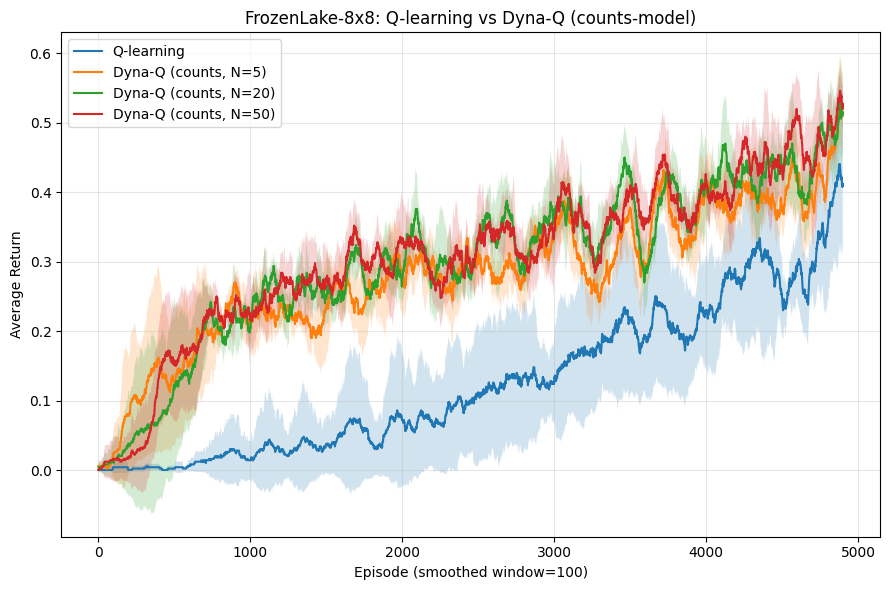

In [57]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# --------------------- Configuration toggles ---------------------
QUICK = False            # If True, use smaller settings for quick testing
COMPARE_MODELS = False   # If True, run additional last-outcome model variant for comparison

# Set parameters based on mode
if QUICK:
    MAP = "8x8"
    EPISODES = 400
    SEEDS = [0, 1]
    DYNA_PLANNING = [5, 20, 40]
    MAX_STEPS = 150
    SMOOTH = 50
else:
    MAP = "8x8"
    EPISODES = 5000
    SEEDS = [0, 1, 2, 3, 4]
    DYNA_PLANNING = [5, 20, 50]
    MAX_STEPS = 300
    SMOOTH = 100

# Learning hyperparameters
ALPHA = 0.1
GAMMA = 0.99
EPS_START, EPS_END = 0.20, 0.01

# --------------------- Environment helper functions ---------------------
def make_env(map_name=MAP, is_slippery=True):
    """Create a FrozenLake gym environment with the given map and slipperiness."""
    return gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery)

def frozenlake_terminals(env):
    """
    Identify terminal states in a FrozenLake environment.
    Returns:
      hole_mask: boolean array of length nS indicating which states are holes.
      goal_idx: integer index of the goal state.
    """
    desc = np.asarray(env.unwrapped.desc)  # environment description (grid layout)
    nrow, ncol = desc.shape
    nS = nrow * ncol
    hole_mask = np.zeros(nS, dtype=bool)
    goal_idx = -1
    # Iterate over grid cells to find holes (H) and goal (G)
    for r in range(nrow):
        for c in range(ncol):
            s = r * ncol + c
            cell = desc[r, c]
            if isinstance(cell, (bytes, np.bytes_)):
                cell = cell.decode("utf-8")  # convert bytes to string if needed
            if cell == 'H':   # hole state
                hole_mask[s] = True
            elif cell == 'G':  # goal state
                goal_idx = s
    return hole_mask, goal_idx

def eps_schedule(ep, total, start=EPS_START, end=EPS_END):
    """Linearly decay epsilon from start to end over the given number of episodes."""
    frac = ep / max(1, total - 1)
    return start + (end - start) * frac

def greedy_rand_row(row, rng):
    """
    Return the index of the maximum value in the array `row`.
    If there are ties for the max value, choose among them uniformly at random.
    """
    max_val = row.max()
    max_idxs = np.flatnonzero(row == max_val)
    # Randomly choose one of the indices with the max value
    return int(rng.choice(max_idxs))

def eps_greedy(Q, state, eps, rng):
    """
    Epsilon-greedy action selection for a given Q-table and state.
    With probability `eps`, a random action is chosen; otherwise, choose the greedy action.
    """
    if rng.random() < eps:
        # Choose a random action
        return int(rng.integers(Q.shape[1]))
    # Choose the greedy action (with random tie-breaking)
    return greedy_rand_row(Q[state], rng)

def moving_average(x, w=SMOOTH):
    """Compute the moving average of array `x` with window size `w`."""
    if len(x) < w:
        return np.array([])
    filt = np.ones(w, dtype=np.float32) / w
    return np.convolve(x, filt, mode="valid")

# --------------------- Q-learning (model-free) ---------------------
def q_learning(n_episodes=EPISODES, alpha=ALPHA, gamma=GAMMA, seed=0,
               map_name=MAP, max_steps=MAX_STEPS):
    """
    Run Q-learning on FrozenLake for `n_episodes` and return the learned Q-table and returns.
    """
    env = make_env(map_name)
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)         # Q-value table
    returns = np.empty(n_episodes, dtype=np.float32)  # track return (sum of rewards) per episode

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)        # epsilon for this episode
        state, _ = env.reset(seed=seed + ep)      # reset environment (with varying seed for randomness)
        G = 0.0                                   # cumulative reward for this episode
        for t in range(max_steps):
            # Epsilon-greedy action selection
            action = eps_greedy(Q, state, eps, rng)
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            # Compute Q-learning target
            best_next = 0.0 if done else Q[next_state].max()
            target = reward + gamma * best_next
            # Update Q-value (incremental update rule)
            Q[state, action] += alpha * (target - Q[state, action])
            G += reward
            if done:
                break  # episode ends if we reach a terminal state (hole or goal)
            state = next_state
        returns[ep] = G
    env.close()
    return Q, returns

# --------------------- Dyna-Q (counts-based model) ---------------------
def dyna_q_counts(n_planning=20, n_episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
                  seed=0, map_name=MAP, max_steps=MAX_STEPS):
    """
    Run Dyna-Q with a counts-based learned model (transition probabilities from state-action counts).
    Returns the learned Q-table and returns per episode.
    """
    env = make_env(map_name)
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n

    # Initialize Q-table and model data structures
    Q = np.zeros((nS, nA), dtype=np.float32)
    returns = np.empty(n_episodes, dtype=np.float32)
    # Model: transition counts and totals for each state-action
    counts = np.zeros((nS, nA, nS), dtype=np.int32)
    totals = np.zeros((nS, nA), dtype=np.int32)
    # Track seen state-action pairs for sampling during planning
    seen_sa = np.empty(nS * nA, dtype=np.int32)  # flat list of seen (state, action) pairs
    seen_count = 0

    # Precompute which states are terminal (holes or goal)
    hole_mask, goal_idx = frozenlake_terminals(env)

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)
        state, _ = env.reset(seed=seed + ep)
        G = 0.0
        for t in range(max_steps):
            # Real step: take action in environment
            action = eps_greedy(Q, state, eps, rng)
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            # Real Q-learning update
            best_next = 0.0 if done else Q[next_state].max()
            target_real = reward + gamma * best_next
            Q[state, action] += alpha * (target_real - Q[state, action])
            # Update model counts for this transition
            counts[state, action, next_state] += 1
            prev_total = totals[state, action]
            totals[state, action] = prev_total + 1
            if prev_total == 0:
                # First time seeing this state-action pair
                seen_sa[seen_count] = state * nA + action
                seen_count += 1

            # Planning: simulate n_planning updates from the learned model
            if n_planning > 0 and seen_count > 0:
                # Sample n_planning random previously seen state-action pairs (with replacement)
                idx_samples = rng.integers(seen_count, size=n_planning)
                sp = seen_sa[idx_samples] // nA  # sampled states
                ap = seen_sa[idx_samples] % nA   # sampled actions
                # Sample next states for each (sp, ap) from the model's probability distribution
                # Compute cumulative sum of counts to form CDF for each sampled pair
                cum_counts = np.cumsum(counts[sp, ap], axis=1)  # shape: (n_planning, nS)
                # Generate random thresholds in [0, totals[sp, ap]) for each sample
                thresholds = rng.random(n_planning) * totals[sp, ap]
                # Determine next state for each sample by finding first index where cum_count exceeds threshold
                bool_matrix = cum_counts >= thresholds[:, None]
                s_next_plan = np.argmax(bool_matrix, axis=1).astype(np.int32)
                # Determine reward and done for these simulated transitions
                r_plan = (s_next_plan == goal_idx).astype(np.float32)    # reward is 1.0 if next state is goal, else 0.0
                d_plan = hole_mask[s_next_plan] | (s_next_plan == goal_idx)  # done if next state is a hole or the goal
                # Compute target values for each planned transition
                targets = np.where(d_plan, 
                                   r_plan, 
                                   r_plan + gamma * Q[s_next_plan].max(axis=1))
                # Update Q for each sampled transition
                if len(np.unique(seen_sa[idx_samples])) == n_planning:
                    # No duplicate (state, action) in this batch: update all at once
                    Q[sp, ap] += alpha * (targets - Q[sp, ap])
                else:
                    # Duplicates present: update sequentially to preserve exact behavior
                    for i in range(n_planning):
                        Q[sp[i], ap[i]] += alpha * (targets[i] - Q[sp[i], ap[i]])
            G += reward
            if done:
                break
            state = next_state
        returns[ep] = G
    env.close()
    return Q, returns

# --------------------- Dyna-Q (last-outcome model) ---------------------
def dyna_q_last(n_planning=20, n_episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
                seed=0, map_name=MAP, max_steps=MAX_STEPS):
    """
    Run Dyna-Q with a simple last-outcome model (each state-action leads to the last observed next-state).
    Returns the learned Q-table and returns per episode.
    """
    env = make_env(map_name)
    rng = np.random.default_rng(seed)
    nS, nA = env.observation_space.n, env.action_space.n

    Q = np.zeros((nS, nA), dtype=np.float32)
    returns = np.empty(n_episodes, dtype=np.float32)
    # Model: store the last observed next-state for each state-action pair
    last_sprime = -np.ones((nS, nA), dtype=np.int32)
    seen_sa = np.empty(nS * nA, dtype=np.int32)
    seen_count = 0

    hole_mask, goal_idx = frozenlake_terminals(env)

    for ep in range(n_episodes):
        eps = eps_schedule(ep, n_episodes)
        state, _ = env.reset(seed=seed + ep)
        G = 0.0
        for t in range(max_steps):
            action = eps_greedy(Q, state, eps, rng)
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            # Real Q-learning update
            best_next = 0.0 if done else Q[next_state].max()
            target_real = reward + gamma * best_next
            Q[state, action] += alpha * (target_real - Q[state, action])
            # Update the last-outcome model for this state-action
            if last_sprime[state, action] == -1:
                # First time seeing this state-action
                seen_sa[seen_count] = state * nA + action
                seen_count += 1
            last_sprime[state, action] = next_state

            # Planning: simulate n_planning transitions using the last-outcome model
            if n_planning > 0 and seen_count > 0:
                idx_samples = rng.integers(seen_count, size=n_planning)
                sp = seen_sa[idx_samples] // nA
                ap = seen_sa[idx_samples] % nA
                s_next_plan = last_sprime[sp, ap]
                r_plan = (s_next_plan == goal_idx).astype(np.float32)
                d_plan = hole_mask[s_next_plan] | (s_next_plan == goal_idx)
                targets = np.where(d_plan, 
                                   r_plan, 
                                   r_plan + gamma * Q[s_next_plan].max(axis=1))
                if len(np.unique(seen_sa[idx_samples])) == n_planning:
                    Q[sp, ap] += alpha * (targets - Q[sp, ap])
                else:
                    for i in range(n_planning):
                        Q[sp[i], ap[i]] += alpha * (targets[i] - Q[sp[i], ap[i]])
            G += reward
            if done:
                break
            state = next_state
        returns[ep] = G
    env.close()
    return Q, returns

# --------------------- Running experiments and plotting ---------------------
def run_many(method, seeds, **kwargs):
    """Run the given training method for multiple seeds and stack the return curves."""
    results = []
    for sd in seeds:
        _, returns = method(seed=sd, **kwargs)
        results.append(returns)
    return np.stack(results, axis=0)  # shape: (len(seeds), n_episodes)

def plot_curves(curves_dict, title):
    """Plot smoothed learning curves (mean ± std deviation) for each label in curves_dict."""
    plt.figure(figsize=(9,6))
    for label, returns_array in curves_dict.items():
        # Compute moving average for smoothing each seed's returns
        smoothed = np.array([moving_average(ret) for ret in returns_array])
        mean = smoothed.mean(axis=0)
        std = smoothed.std(axis=0)
        xs = np.arange(len(mean))
        plt.plot(xs, mean, label=label)
        plt.fill_between(xs, mean - std, mean + std, alpha=0.2)
    plt.xlabel(f"Episode (smoothed window={SMOOTH})")
    plt.ylabel("Average Return")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------- Execute study (if run as a script) ---------------------
if __name__ == "__main__":
    # Run Q-learning baseline
    q_returns = run_many(q_learning, SEEDS, n_episodes=EPISODES, map_name=MAP)
    curves = {"Q-learning": q_returns}
    # Run Dyna-Q with counts-based model for various planning step counts
    for N in DYNA_PLANNING:
        dyna_rets = run_many(dyna_q_counts, SEEDS, n_planning=N,
                              n_episodes=EPISODES, map_name=MAP)
        curves[f"Dyna-Q (counts, N={N})"] = dyna_rets
    # Plot Q-learning vs Dyna-Q results
    plot_curves(curves, title=f"FrozenLake-{MAP}: Q-learning vs Dyna-Q (counts-model)")
    # Optionally, compare counts-based model vs last-outcome model variants
    if COMPARE_MODELS:
        compare_curves = {
            "Dyna-Q (counts model)": run_many(dyna_q_counts, SEEDS, n_planning=20,
                                              n_episodes=EPISODES, map_name=MAP),
            "Dyna-Q (last-outcome model)": run_many(dyna_q_last, SEEDS, n_planning=20,
                                                    n_episodes=EPISODES, map_name=MAP)
        }
        plot_curves(compare_curves, title=f"FrozenLake-{MAP}: Dyna-Q model variants")


# Discussion

Dyna-Q helps in FrozenLake because it does not only learn from the real steps taken in the environment, but also uses a model to imagine extra experiences and update the Q-values faster. The number of planning steps N controls how many of these imagined updates happen after each real step: small N means slower learning, while larger N lets the agent improve much more quickly since it reuses past knowledge many times. Having a model that keeps track of multiple possible next states is important in FrozenLake because the environment is slippery and the same action can lead to different outcomes; by modeling these different possibilities, the agent learns more realistic values and avoids being misled by only the last outcome.